In [1]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from pandas.core.algorithms import mode
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Get Ticker Data
company = "BTC-USD"

start = dt.datetime(2012, 1, 1)
end = dt.datetime.today()

data = web.DataReader(company, "yahoo", start, end)
print(data.head())

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))


                  High         Low        Open       Close      Volume  \
Date                                                                     
2014-09-16  468.174011  452.421997  465.864014  457.334015  21056800.0   
2014-09-17  456.859985  413.104004  456.859985  424.440002  34483200.0   
2014-09-18  427.834991  384.532013  424.102997  394.795990  37919700.0   
2014-09-19  423.295990  389.882996  394.673004  408.903992  36863600.0   
2014-09-20  412.425995  393.181000  408.084991  398.821014  26580100.0   

             Adj Close  
Date                    
2014-09-16  457.334015  
2014-09-17  424.440002  
2014-09-18  394.795990  
2014-09-19  408.903992  
2014-09-20  398.821014  


In [8]:
# Window Size and Data Preproccessing
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days : x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
# Building the Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)
model.save(filepath=f"models/BTC-USD")


79/79 [==============================] - 7s 49ms/step - loss: 0.0051


INFO:tensorflow:Assets written to: models/BTC-USD\assets


INFO:tensorflow:Assets written to: models/BTC-USD\assets


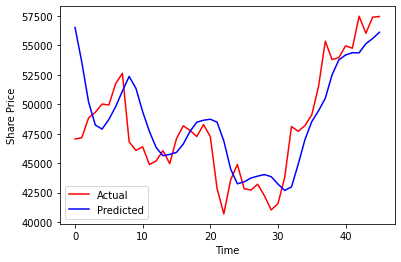

In [15]:
# Testing the accuracy using previous data
test_end = dt.datetime.today()
test_start = test_end - dt.timedelta(45)

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Making Prediction
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days : x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[-1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plotting the results
plt.plot(actual_prices, color="red", label="Actual")
plt.plot(predicted_prices, color="blue", label="Predicted")
plt.xlabel("Time")
plt.ylabel("Share Price")
plt.legend()
plt.show()

61
[[56538.043]]
[[56463.63]]
[[56176.887]]
[[55839.066]]
[[55524.734]]
[[55260.7]]
[[55052.527]]
[[54896.555]]
[[54785.074]]
[[54708.832]]
[[54658.58]]
[[54625.973]]
[[54604.094]]
[[54587.617]]
[[54572.777]]
[[54557.195]]
[[54539.58]]
[[54519.47]]
[[54496.99]]
[[54472.547]]
[[54446.76]]
[[54420.26]]
[[54393.63]]
[[54367.344]]
[[54341.766]]
[[54317.184]]
[[54293.723]]
[[54271.465]]
[[54250.42]]
[[54230.59]]


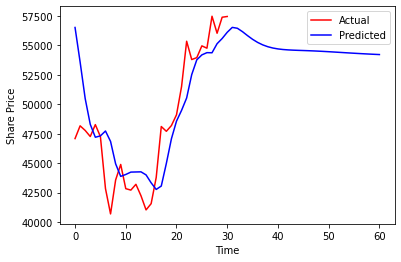

In [13]:
# Predicting future stock prices
prediction_dataset = total_dataset[-prediction_days - 1:].values
print(len(prediction_dataset))
predicted_values = []

for i in range(1, 31):
    model_inputs = prediction_dataset.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    real_data = [
        model_inputs[-prediction_days : len(model_inputs) + 1, 0]
    ]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)
    
    print(prediction)
    predicted_values.append(float(prediction))
    prediction_dataset = np.append(prediction_dataset, float(prediction))

predicted_graph = [float(i) for i in predicted_prices] + predicted_values
plt.plot(actual_prices, color="red", label="Actual")
plt.plot(predicted_graph, color="blue", label="Predicted")
plt.xlabel("Time")
plt.ylabel("Share Price")
plt.legend()
plt.show()

